In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
S0 = 100.0
sigma = 0.2
r = 0.05
K = 100.0
T = 1.0
mu = 0.07
num_simulations = 100000
num_days = 252
hedge_freq = {"monthly": 21, "weekly": 5, "daily": 1}

# Final P&L at Maturity Performing a Continuous Delta Hedge

#### Underlying Stock Dynamics
The stock price $S_t$ follows the SDE given by:
$$
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t
$$
where $\mu$ is the drift (expected return), $\sigma$ is the volatility, and $dW_t$ is the increment of a Wiener process.

#### Black-Scholes-Merton Delta Hedging
- **Option Premium**: Upon selling the call option, you receive an option premium calculated using the Black-Scholes formula:
  $$
  C = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)
  $$
  where:
  - $C$ is the call option price.
  - $S_0$ is the initial stock price.
  - $K$ is the strike price.
  - $T$ is the time to maturity.
  - $r$ is the risk-free interest rate.
  - $\sigma$ is the volatility.
  - $\Phi$ is the cumulative distribution function of the standard normal distribution.
  - $d_1 = \frac{\ln(\frac{S_0}{K}) + (r + \frac{\sigma^2}{2})T}{\sigma \sqrt{T}}$
  - $d_2 = d_1 - \sigma \sqrt{T}$

- **Delta** ($\Delta$): The sensitivity of the option price to a small change in the stock price, given by $\Delta = \Phi(d_1)$.

#### Hedging the Position
- **Delta Hedging Strategy**: Continuously adjust the position in the underlying stock to maintain a delta-neutral position, protecting you from changes in the stock price:
  $$
  \text{Change in portfolio} = \Delta \, dS_t = \Phi(d_1) (\mu S_t \, dt + \sigma S_t \, dW_t)
  $$

#### Final PnL 
- **At Maturity**: The final payout of the option (if exercised) is $\max(S_T - K, 0)$.
- **Total PnL**: In an ideal Black-Scholes world, the expected PnL from such a strategy should theoretically be zero, implying that the premium received upfront should equal the cost to hedge the position plus the payout of the option at maturity. Any deviation from this zero PnL would typically arise from discrete hedging, transaction costs, model inaccuracies, and so on.


# Distribution of Final P&L at Maturity Performing a Monthly, Weekly, and Daily Delta Hedge

In [3]:
def pnl_simulation(S0, K, T, r, sigma, num_simulations, num_days, hedge_freq):
    dt = T / num_days
    daily_adjustment = (r - 0.5 * sigma**2) * dt
    daily_volatility = sigma * np.sqrt(dt)

    daily_returns = np.random.normal(daily_adjustment, daily_volatility, (num_simulations, num_days))
    stock_prices = S0 * np.exp(np.cumsum(daily_returns, axis=1))
    T_remaining = T - dt * np.arange(num_days)
    d1 = (np.log(stock_prices / K) + (r + 0.5 * sigma**2) * T_remaining[None, :]) / (sigma * np.sqrt(T_remaining[None, :]))
    delta_matrix = norm.cdf(d1)

    final_pnl = {}
    
    for freq, interval in hedge_freq.items():
        pnl = np.zeros(num_simulations)
        hedge_days = np.arange(interval - 1, num_days, interval)
        
        for i in range(len(hedge_days) - 1):
            day_start = hedge_days[i]
            day_end = hedge_days[i + 1]
            
            pnl_changes = delta_matrix[:, day_start:day_end] * np.diff(stock_prices[:, day_start:day_end + 1], axis=1)
            pnl += np.sum(pnl_changes, axis=1)
        
        pnl += np.maximum(stock_prices[:, -1] - K, 0) - delta_matrix[:, -1] * (stock_prices[:, -1] - stock_prices[:, hedge_days[-1]])
        final_pnl[freq] = pnl

    return final_pnl

pnl_results = pnl_simulation(S0, K, T, r, sigma, num_simulations, num_days, hedge_freq)

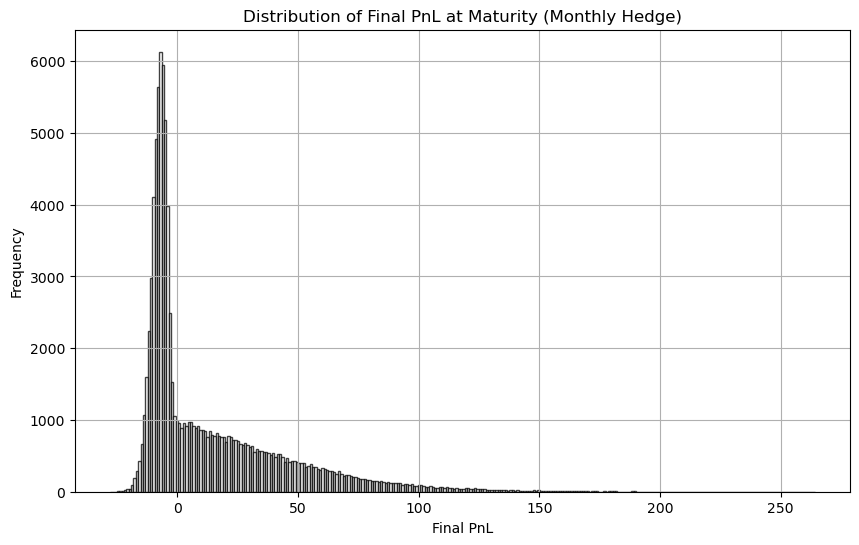

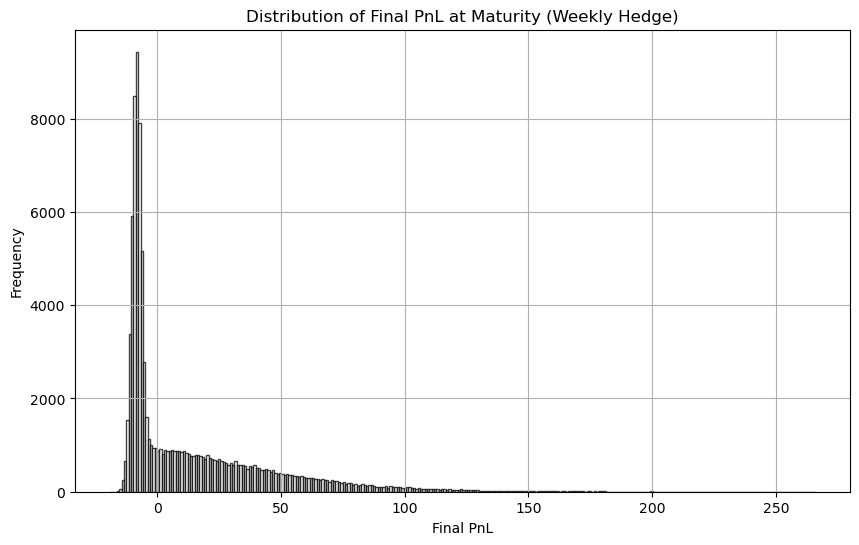

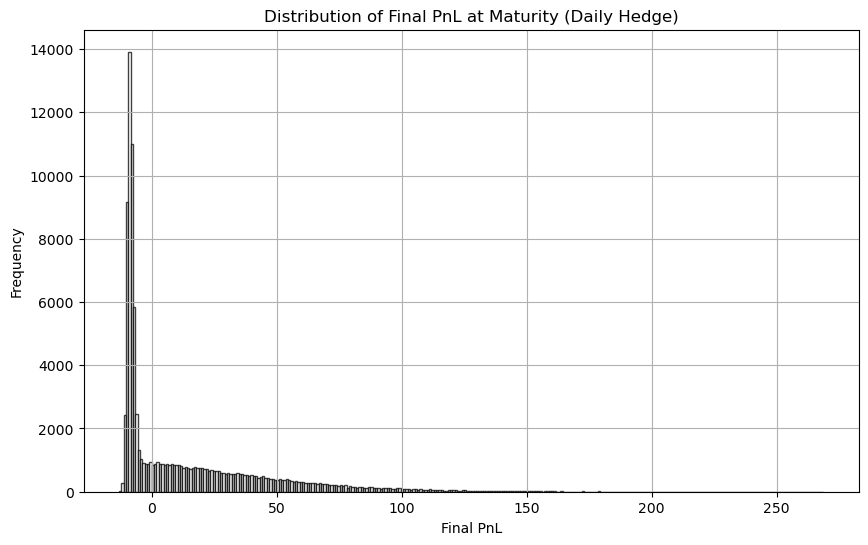

In [4]:
for freq, pnl_values in pnl_results.items():
    plt.figure(figsize=(10, 6))
    plt.hist(pnl_values, bins=300, alpha=0.75, color='white', edgecolor='black')
    plt.title(f"Distribution of Final PnL at Maturity ({freq.capitalize()} Hedge)")
    plt.xlabel("Final PnL")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Conclusion

### Analysis of Final PnL Distribution Across Different Hedging Frequencies

#### Concentration Around Zero PnL
- **Observation**: All three distributions are centered around at zero, suggesting that the delta hedging strategy effectively neutralizes most of the risk associated with movements in the underlying stock. This is evident as the theoretical expectation under perfect hedging conditions is that the PnL should ideally be zero.
- **Implication**: The alignment with zero indicates that the hedging, to a varying degree, matches the theoretical outcomes expected from such strategies.

#### Impact of Hedging Frequency
- **Observation**: The peak of the PnL distribution becomes increasingly sharper and more concentrated around zero as the frequency of hedging increases from monthly to daily.
- **Implication**: More frequent hedging more effectively minimizes the variability in PnL, reducing the risk of the hedged portfolio deviating from its delta-neutral position.

#### Spread and Tail Behavior
- **Observation**: The monthly hedging shows a broader spread and longer tails in the PnL distribution compared to daily and weekly hedging.
- **Implication**: This indicates a higher variance in PnL and a greater likelihood of significant gains or losses. Less frequent adjustments mean that larger price movements are not countered promptly, increasing risk.

#### Risk Reduction Through Increased Frequency
- **Observation**: Daily hedging results in the narrowest PnL spread around zero, showing the lowest risk in terms of PnL variability.
- **Implication**: More frequent rebalancing helps the hedging portfolio better track and respond to changes in the underlying asset. 

#### Practicality
- **Consideration**: While daily hedging seems most effective in risk reduction, it may involve higher transaction costs and greater operational complexities.
- **Decision Factors**: The choice of hedging frequency should consider the balance between reduced risk and increased operational costs to determine the optimal strategy.